In [1]:
import openmc
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from math import pi

In [2]:
# Materials
fuel = openmc.Material(name='uo2')
fuel.set_density('g/cc',10.96)
fuel.add_nuclide('U234', 0.000090, 'ao')
fuel.add_nuclide('U235', 0.010124, 'ao')
fuel.add_nuclide('U236', 0.000046, 'ao')
fuel.add_nuclide('U238', 0.323072, 'ao')
fuel.add_element('O', 0.666667, 'ao')
#fuel.remove_nuclide('O17')
fuel.depletable = True



clad = openmc.Material(name='Zirc4')
clad.set_density('g/cc', 6.56)
clad.add_element('O', 0.006790, 'ao')
clad.add_element('Cr', 0.001741, 'ao')
clad.add_element('Fe', 0.003242, 'ao')
clad.add_element('Zr', 0.977549, 'ao')
clad.add_element('Sn', 0.010677, 'ao')

air = openmc.Material(name="air");
air.add_element('O',0.2);
air.add_element('N',0.8);
air.set_density('g/cm3',1.3e-3);



In [3]:
# geometry
# dimensions from AP1000 Design Control Document, Rev 19, Tier 2, Chapter 4, Section 4.1
# https://www.nrc.gov/docs/ML1117/ML11171A443.pdf, table 4.1-1
h_fuel = 426.7;
r_fuel = 0.4178;
r_pin = 0.475;
clad_t = r_pin - r_fuel; # ignore gap
pin_pitch = 1.26;

N_pin_assy = 17;
assy_pitch = N_pin_assy*pin_pitch

h_outer = 1.1*h_fuel; # height of cylinder for the tally surface
r_outer = assy_pitch/2. + 100.; # roughly 1m from the outside of the assembly

# basic surfaces

fuel_outer = openmc.model.RightCircularCylinder([0.,0.,-h_fuel/2],h_fuel,radius=r_fuel,
                                             axis='z');
clad_outer = openmc.model.RightCircularCylinder([0.,0.,-h_fuel/2-clad_t],
                                                h_fuel+2*clad_t,radius=r_pin,
                                               axis = 'z');

# fuel pin universe

fp_fuel = openmc.Cell(name='fuel');
fp_fuel.fill = fuel;
fp_fuel.region = -fuel_outer

fp_clad = openmc.Cell(name='fuel clad');
fp_clad.fill = clad;
fp_clad.region = +fuel_outer & -clad_outer

fp_air = openmc.Cell(name='air around fuel')
fp_air.fill = air;
fp_air.region = +clad_outer

fp = openmc.Universe();
fp.add_cells((fp_fuel,fp_clad,fp_air));




In [4]:
# some colors for plotting
colors = {}
colors[fuel] = 'yellow';
colors[clad] = 'gray';
colors[air] = 'pink';

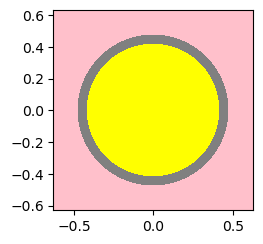

In [5]:
fp.plot(width=(pin_pitch,pin_pitch),
        color_by='material',colors=colors)

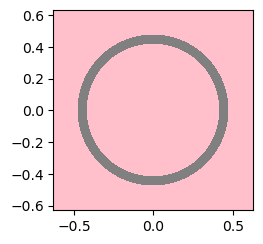

In [6]:
# guide tube universe
gt_inner = openmc.Cell(name='gt inner')
gt_inner.fill = air;
gt_inner.region = -fuel_outer

gt_clad = openmc.Cell(name='gt clad')
gt_clad.fill = clad;
gt_clad.region = +fuel_outer & -clad_outer

gt_outer = openmc.Cell(name='gt outer')
gt_outer.fill = air;
gt_outer.region = +clad_outer

gt = openmc.Universe()
gt.add_cells((gt_inner,gt_clad,gt_outer));

gt.plot(width=(pin_pitch,pin_pitch),
        color_by='material',colors=colors)

In [7]:
# "All air" universe to serve as the "outer" universe
just_air_cell = openmc.Cell(name='just air')
just_air_cell.fill = air

just_air = openmc.Universe();
just_air.add_cell(just_air_cell);


In [8]:
assy_outer = openmc.model.RectangularParallelepiped(-assy_pitch/2.,assy_pitch/2.,-assy_pitch/2.,assy_pitch/2.,
                                                    -h_fuel/2.-clad_t,h_fuel/2.+clad_t);

# assembly layout based on AP1000 DCD Rev 19, Tier 2, Chapter 4, Section 4.2
# figure 4.2-1.
# https://www.nrc.gov/docs/ML1117/ML11171A444.pdf

assy_lattice = openmc.RectLattice()
assy_lattice.dimension = [17,17];
assy_lattice.lower_left = [-assy_pitch/2,-assy_pitch/2];
assy_lattice.pitch = [pin_pitch,pin_pitch];
assy_lattice.universes = [
    [fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp],
    [fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp],
    [fp,fp,fp,fp,fp,gt,fp,fp,gt,fp,fp,gt,fp,fp,fp,fp,fp],
    [fp,fp,fp,gt,fp,fp,fp,fp,fp,fp,fp,fp,fp,gt,fp,fp,fp],
    [fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp],
    [fp,fp,gt,fp,fp,gt,fp,fp,gt,fp,fp,gt,fp,fp,gt,fp,fp],
    [fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp],
    [fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp],
    [fp,fp,gt,fp,fp,gt,fp,fp,gt,fp,fp,gt,fp,fp,gt,fp,fp],
    [fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp],
    [fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp],
    [fp,fp,gt,fp,fp,gt,fp,fp,gt,fp,fp,gt,fp,fp,gt,fp,fp],
    [fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp],
    [fp,fp,fp,gt,fp,fp,fp,fp,fp,fp,fp,fp,fp,gt,fp,fp,fp],
    [fp,fp,fp,fp,fp,gt,fp,fp,gt,fp,fp,gt,fp,fp,fp,fp,fp],
    [fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp],
    [fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp,fp]
];

assy_lattice.outer = just_air;

tally_surface = openmc.model.RightCircularCylinder([0.,0.,-h_outer/2.],h_outer,r_outer,
                                                  boundary_type = 'vacuum');

assy_cell = openmc.Cell(name='assy')
assy_cell.fill = assy_lattice;
assy_cell.region = -assy_outer;

air_cell = openmc.Cell(name='air cell')
air_cell.fill = air;
air_cell.region = +assy_outer & -tally_surface

root = openmc.Universe();
root.add_cells([assy_cell,air_cell]);

g = openmc.Geometry();
g.root_universe = root;
g.export_to_xml();

fuel.volume = (17.*17. - 25.)*np.pi*(r_fuel**2)*h_fuel;
materials = openmc.Materials([fuel,clad,air])
mf = openmc.Materials();
mf += [fuel,clad,air];
mf.export_to_xml();


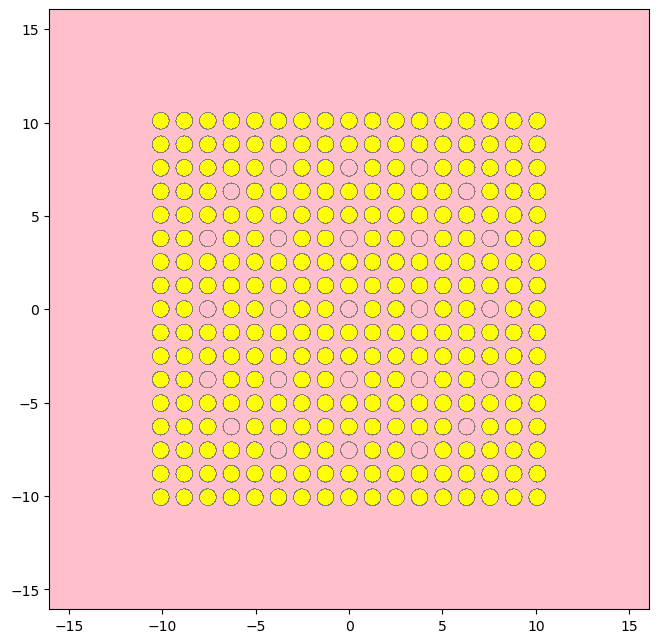

In [9]:
root.plot(width=(1.5*assy_pitch,1.5*assy_pitch),
        color_by='material',colors=colors,
         pixels=(600,600))

In [10]:
fuel_activity = fuel.get_activity(by_nuclide=True,units='Bq')

In [11]:
print(fuel_activity['U235']) # just to be sure...

1431665069.8197637


In [12]:
# make my tally
flux = openmc.Tally(name = 'flux');
energy,dose = openmc.data.dose_coefficients('photon','ISO');
dose_filter = openmc.EnergyFunctionFilter(energy,dose);
surface_filter = openmc.SurfaceFilter(tally_surface.cyl);

flux.filters = [dose_filter,surface_filter];
flux.scores = ['current'];
tallies = openmc.Tallies([flux]);
tallies.export_to_xml();

In [13]:
# Read data and make my source
u235_data = openmc.data.Decay('u235_data');
u238_data = openmc.data.Decay('u238_data');

u235_p_src = u235_data.sources['photon'];
u238_p_src = u238_data.sources['photon'];

# sample space
x_uni = openmc.stats.Uniform(a=-assy_pitch/2.,b=assy_pitch/2.);
y_uni = openmc.stats.Uniform(a=-assy_pitch/2.,b=assy_pitch/2.);
z_uni = openmc.stats.Uniform(a=-h_fuel/2.,b=h_fuel/2.);
sample_space = openmc.stats.CartesianIndependent(x_uni,y_uni,z_uni);


src_u235 = openmc.Source(space=sample_space,energy=u235_p_src,particle='photon');
src_u235.strength=fuel_activity['U235'];

src_u238 = openmc.Source(space=sample_space,energy=u238_p_src,particle='photon');
src_u238.strength=fuel_activity['U238'];

settings = openmc.Settings();
settings.run_mode = 'fixed source';
settings.batches = 100;
settings.particles = 50000;
settings.source = [src_u235,src_u238];

settings.export_to_xml();


In [14]:
openmc.run()

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                #########

In [15]:
sp = openmc.StatePoint('statepoint.100.h5');

dose_t = sp.get_tally(name='flux');
dose_df = dose_t.get_pandas_dataframe();

In [16]:
current = dose_df['mean']

conv_pSv_to_rem = 1e-10
surf_area = 2*np.pi*(r_outer)*h_outer # cm^2 for pin
time = 3600

current = current*conv_pSv_to_rem*time/surf_area
print('The dose is approximately %.4g rem/hr' % current)

The dose is approximately 4.076e-05 rem/hr
